# MELI challenge for DS 

# Caso de negocio escogido:

Dentro del marketplace existen productos similares o idénticos entre sí (son
productos vendidos por distintos sellers, en la api puedes obtener y descargar los
títulos e incluso las imágenes!). ¿Cómo buscar dichos ítems para agruparlos y
volverlos comparables entre sí? Esto permitiría mejorar la experiencia ante muchas
opciones similares.

### Hipotesis:

Las categorias de Salud y Equipamento médico con Deportes y Fitness puede estar mal categorizadas, pueden estar vendiendo los objetos cruzados y dando recomendaciones erroneas al usuario

# Analisis descriptivo y exploratorio de los datos

A continuación haremos un análisis exploratorio de los datos extraidos y evaluaremos si la hipitesis en la que nos basamos puede tener sentido

El objetivo principal es a partir de los productos de marketplace, mirar as distribución entre los diferentes productos y se responderan los siguientes puntos:

* Que representación tiene las 2 categorias de interés respecto a las demas?
* Precio promedio de pro categoria , descuento promedio
* Nube de palabras para saber qué es lo que más se vende segun el nombre del título



In [1]:
# librerias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

# for NLP
import gensim
from gensim import corpora, models


In [2]:
import os
os.getcwd()
os.chdir('/Users/cindyzhang/Documents/meli_test_cindy')

In [3]:
import sys
sys.path.append('src')  # Change path

from src import data_extraction, images_extraction
from data_extraction import *
from images_extraction import *

from src import preprocess_text 
from src.preprocess_text import *

In [5]:
df_extract=data_extraction(country_name='Colombia')
site_id=df_extract.return_site_id(country='Colombia')
df_cat=df_extract.return_cat_id(country_id=site_id)

In [6]:
n_items=[requests.get(f'https://api.mercadolibre.com/categories/{category_id}').json().get("total_items_in_this_category") for category_id in df_cat['id']]
df_cat=pd.concat([df_cat,pd.DataFrame({'n_items':n_items})],axis=1)

df_cat['p_items']=round(100*df_cat['n_items']/sum(df_cat['n_items']),1)
df_cat.sort_values('n_items',ascending=False,inplace=True)
# crar una columna para mostrar por millones 
df_cat['n_items_M']=df_cat['n_items']/1000000


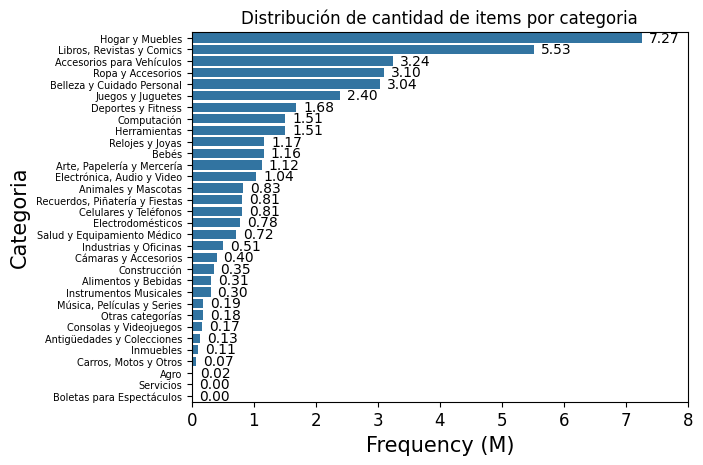

In [7]:
ax=sns.barplot(y='name',x='n_items_M',data=df_cat)
ax.set_ylabel('Categoria',fontsize=15)
ax.set_xlabel('Frequency (M)',fontsize=15)

ax.tick_params(axis='x', labelsize=12) # Para el eje x
ax.tick_params(axis='y', labelsize=7) # Para el eje y
plt.title("Distribución de cantidad de items por categoria")
# Agregar los textos de los valores de las barras
#for i, p in enumerate(ax.patches):
#    ax.annotate(str(df_cat['p_items'].iloc[i])+'%', (p.get_x() + p.get_width(), p.get_y() + p.get_height()/2), 
#                xytext=(5, 0), textcoords='offset points', ha='left', va='center')
for p in ax.patches:
    ax.annotate("%.2f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y() + p.get_height()/2), 
                xytext=(5, 0), textcoords='offset points', ha='left', va='center')

plt.xlim(0,8)
plt.show()


### leyendo los datos de las categorias de interés

In [8]:
#leyendo los dataframes extraidos
df_items1=pd.read_csv("./data/df_items_MCO180800.csv") # salud y equipos medicos
df_items2=pd.read_csv("./data/df_items_MCO1276.csv") # Deporte y fitness
#agregando una etiqueta para saber el nombre de la categoria
df_items1['cat_name']='Sal. & Eq.Med'
df_items2['cat_name']='Dep & Fit'
df_all_items=pd.concat([df_items1,df_items2],axis=0)
print("tamaño del dataFrame:", df_all_items.shape)

tamaño del dataFrame: (2100, 59)


### 1. Tipo de id por categoria

In [9]:
#Genera Tabla Cruzada
tabla_cruzada = pd.crosstab(df_all_items['cat_name'], df_all_items['listing_type_id'], dropna=False)
#renombra columnas
tabla_cruzada = tabla_cruzada.reset_index(drop=False).rename_axis(" ", axis='columns')
tabla_cruzada

,cat_name,gold_pro,gold_special
0,Dep & Fit,200,850
1,Sal. & Eq.Med,350,700


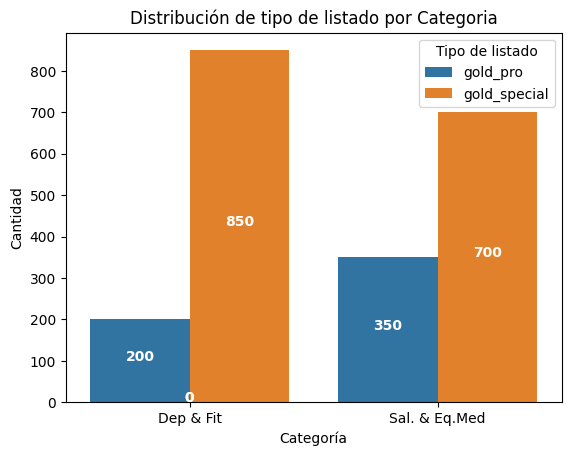

In [10]:
df=(
    df_all_items
    .groupby(['cat_name','listing_type_id'])
    .agg({'id':'count'})
    .reset_index(drop=False)
    .rename(columns={'id':'n'})
    )
df['p']=df.groupby('cat_name')['n'].transform(lambda x: round(100*x/sum(x),1))

ax=sns.barplot(data=df, x='cat_name', y='n', hue='listing_type_id')  # Cambia '1' al número de la columna que desees graficar

# Agrega etiquetas de texto
# Etiquetas
for bar in ax.patches:
  ax.text(bar.get_x() + bar.get_width() / 2,
          bar.get_height() / 2 + bar.get_y(),
          round(bar.get_height()), ha = 'center',
          color = 'w', weight = 'bold', size = 10)
    
# Personaliza el gráfico
plt.title('Distribución de tipo de listado por Categoria')
plt.xlabel('Categoría')
plt.ylabel('Cantidad')
plt.xticks(rotation=0)  # Rotar las etiquetas del eje x para una mejor legibilidad
plt.legend(title='Tipo de listado')  # Agrega leyenda con título

# Muestra la gráfica
plt.show()

### 2. Tipo de logistica por la categoria

In [11]:
df_items1['logistic_type'].value_counts()

logistic_type
cross_docking    457
xd_drop_off      296
fulfillment      243
drop_off          52
custom             2
Name: count, dtype: int64

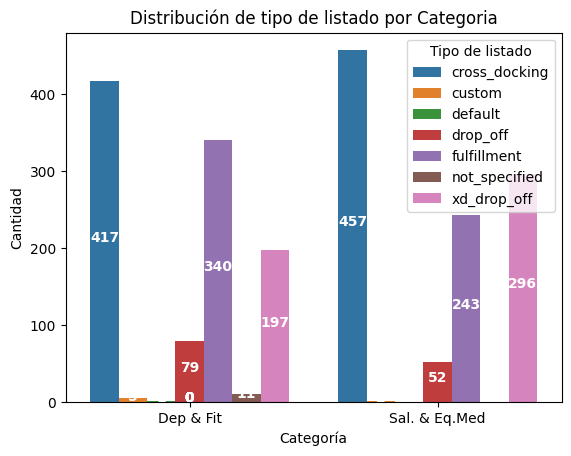

In [12]:
df=(
    df_all_items
    .groupby(['cat_name','logistic_type'])
    .agg({'id':'count'})
    .reset_index(drop=False)
    .rename(columns={'id':'n'})
    )
df['p']=df.groupby('cat_name')['n'].transform(lambda x: round(100*x/sum(x),1))

ax=sns.barplot(data=df, x='cat_name', y='n', hue='logistic_type')  # Cambia '1' al número de la columna que desees graficar

# Agrega etiquetas de texto
# Etiquetas
for bar in ax.patches:
  ax.text(bar.get_x() + bar.get_width() / 2,
          bar.get_height() / 2 + bar.get_y(),
          round(bar.get_height()), ha = 'center',
          color = 'w', weight = 'bold', size = 10)
    
# Personaliza el gráfico
plt.title('Distribución de tipo de listado por Categoria')
plt.xlabel('Categoría')
plt.ylabel('Cantidad')
plt.xticks(rotation=0)  # Rotar las etiquetas del eje x para una mejor legibilidad
plt.legend(title='Tipo de listado')  # Agrega leyenda con título

# Muestra la gráfica
plt.show()

### 3. Distribución de los precios promedios en cada uno

Text(0.5, 0, 'Categoria')

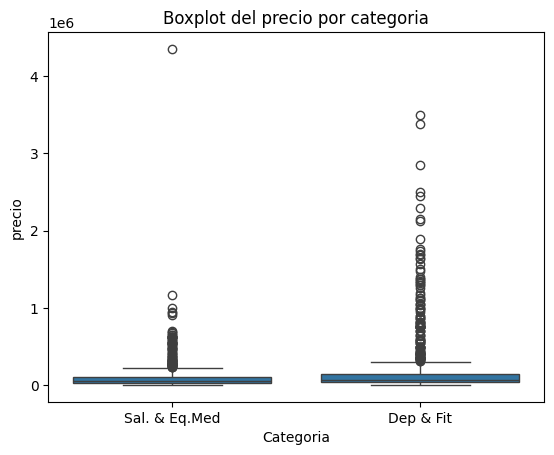

In [13]:
ax = sns.boxplot(x="cat_name", y="price", data=df_all_items)
plt.title("Boxplot del precio por categoria")
plt.ylabel("precio")
plt.xlabel("Categoria")

### 4. Analisis descriptivo a partir de los títulos

A continuación vamos a trabajar con los títulos de los items y hacer un analisis sobre el texto de cada uno, eliminando stopwords, creando un corpus y un diccionario para poder modelar los principales tópicos de los cuales se pueden agrupar. PAra esto se utilzan tecnicas de embeding y principalmente la libreria gensim.

In [14]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import matplotlib.pyplot as plt
import re
# Descargar las palabras vacías (stopwords) si aún no están descargadas
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cindyzhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/cindyzhang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### 4.1 Limpieza de los textos y wordcloud

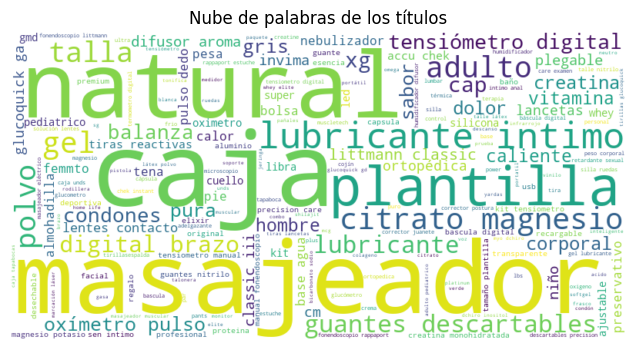

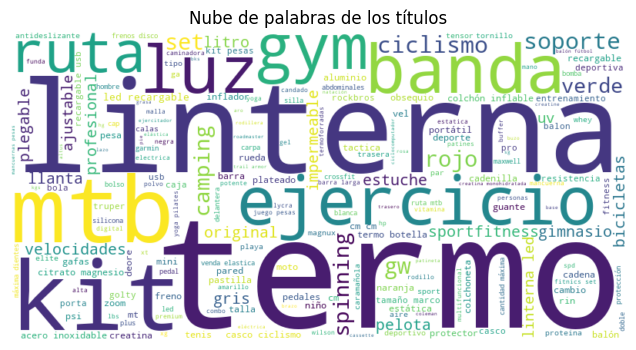

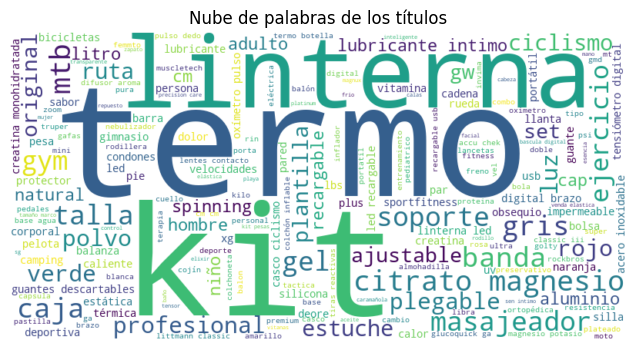

In [11]:
list_items1=list(df_items1['title'])
list_items2=list(df_items2['title'])
list_items_all=list(df_all_items['title'])



clean_text1=preprocess_text.clean_text(list_items1)
clean_text2=preprocess_text.clean_text(list_items2)
clean_text_all=preprocess_text.clean_text(list_items_all)


preprocess_text.generate_wordcloud(clean_text1)
preprocess_text.generate_wordcloud(clean_text2)
preprocess_text.generate_wordcloud(clean_text_all)

#### 4.2 Prepracion para un modelo de tópicos LDA (Latent Dirichleth Analisis)

El modelo de tópicos se utiliza para descubrir patrones semánticos en el corpus de un texto , es no supervisado y analiza e identifica clusters o grupos similares. Encontrar las diferentes combinaciones que pueden hacer en los topicos dentro de las dos categorias identificando individualmente y combinada nos puede ayudar a ver el tipo de productos que son comparables entre ellos 


Se toman finalmente los textos de ambos grupos de categorias para comparar los topicos que se generan en ambos

In [14]:
# Tokenizar el texto en palabras nuevamente
tokens = word_tokenize(clean_text_all)
# Create Dictionary
id2word = corpora.Dictionary([tokens])
# Create Corpus
texts =[tokens]
# Term Document Frequency
# covierte los documentos en una bolsa de plaabras
corpus = [id2word.doc2bow(tokens)]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 2), (2, 2), (3, 2), (4, 1), (5, 8), (6, 1), (7, 1), (8, 2), (9, 2), (10, 1), (11, 1), (12, 12), (13, 5), (14, 1), (15, 9), (16, 1), (17, 23), (18, 2), (19, 12), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 7), (27, 1), (28, 2), (29, 3)]


In [15]:
# Entrenar el modelo LDA
lda_model = models.LdaModel(corpus, 
                            num_topics=5, 
                            id2word=id2word)
"""
                            random_state=100,
                            update_every=1,
                            chunksize=10,
                            passes=10,
                            alpha='symmetric',
                            iterations=100,
                            per_word_topics=True)

"""

# Imprimir los tópicos generados por el modelo
for topic in lda_model.print_topics():
    print(topic)

(0, '0.006*"digital" + 0.005*"kit" + 0.004*"guantes" + 0.004*"linterna" + 0.004*"termo" + 0.004*"lubricante" + 0.004*"caja" + 0.004*"magnesio" + 0.003*"creatina" + 0.003*"citrato"')
(1, '0.006*"termo" + 0.005*"linterna" + 0.005*"kit" + 0.004*"guantes" + 0.004*"digital" + 0.004*"caja" + 0.004*"mtb" + 0.004*"gel" + 0.004*"led" + 0.004*"masajeador"')
(2, '0.005*"digital" + 0.005*"magnesio" + 0.005*"lubricante" + 0.004*"caja" + 0.004*"recargable" + 0.004*"termo" + 0.004*"creatina" + 0.003*"kit" + 0.003*"led" + 0.003*"mtb"')
(3, '0.006*"digital" + 0.006*"kit" + 0.005*"magnesio" + 0.005*"lubricante" + 0.005*"led" + 0.005*"linterna" + 0.004*"ciclismo" + 0.004*"recargable" + 0.004*"masajeador" + 0.004*"termo"')
(4, '0.006*"digital" + 0.005*"kit" + 0.004*"lubricante" + 0.004*"magnesio" + 0.004*"termo" + 0.004*"guantes" + 0.004*"linterna" + 0.004*"caja" + 0.004*"led" + 0.004*"citrato"')


Acá podemos ver que los 5 topicos creados contienen las plabras como kit, guantes, digital, termino, lubricante, magnesio, creatina y citrato

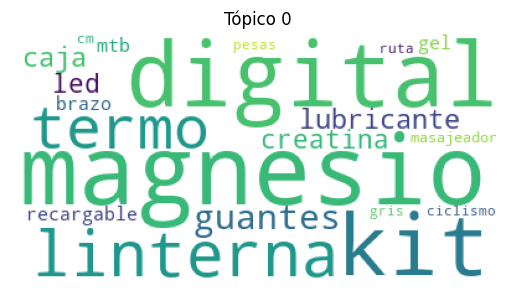

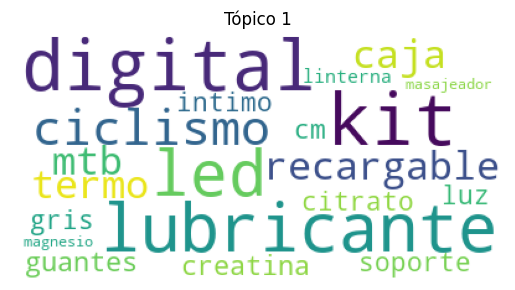

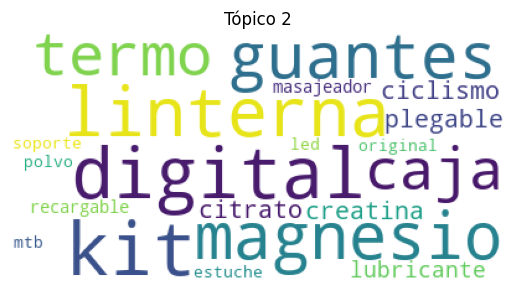

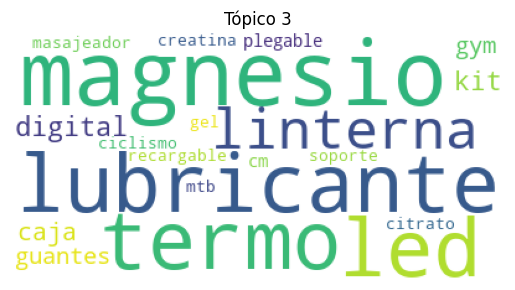

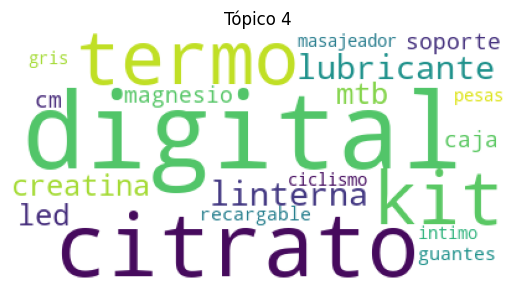

In [21]:
for i in range(0, 5):
    plt.figure()
    plt.imshow(WordCloud(background_color='white', prefer_horizontal=1.0)
               .fit_words(dict(lda_model.show_topic(i, 20))))
    plt.axis("off")
    plt.title("Tópico " + str(i))
    plt.show()

In [22]:
### guardamos el modelo
lda_model.save("./results/lda_model.model")
id2word.save("./texto_diccionario.dictionary")

El topico más dominante puede ser 

#### 4.4 También podemos emepzar a trabajar con bigramas o trigramas

In [24]:
bigram = gensim.models.Phrases(texts, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[texts], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

### 5. Conclusiones

Mediante los topicos analizados, se encuentra que en ambas categorias las palabras pueden no tener mucho en común, sin embargo dado el origen pueden pertenecer de un lado o el otro.